# SWE-Bench-CL Dataset Construction
This notebook generates the `SWE-Bench-CL` dataset from the original `SWE-Bench_Verified` dataset provided on [HuggingFace](https://huggingface.co/datasets/princeton-nlp/SWE-bench_Verified). The resulting dataset is structured for continual learning evaluation with sequential tasks, difficulty-based curricula, and dependency tracking.

In [8]:
import pandas as pd
import numpy as np
import json
import re
from datetime import datetime
from tqdm import tqdm
import os

# For reproducibility
np.random.seed(42)

In [9]:
## 1. Load the Original Dataset

# Login using e.g. `huggingface-cli login` to access this dataset
df = pd.read_parquet("hf://datasets/princeton-nlp/SWE-bench_Verified/data/test-00000-of-00001.parquet")

# Display basic information
print(f"Total issues: {len(df)}")
print(f"Repositories: {df['repo'].nunique()}")
print(f"Columns: {df.columns.tolist()}")

Total issues: 500
Repositories: 12
Columns: ['repo', 'instance_id', 'base_commit', 'patch', 'test_patch', 'problem_statement', 'hints_text', 'created_at', 'version', 'FAIL_TO_PASS', 'PASS_TO_PASS', 'environment_setup_commit', 'difficulty']


In [10]:
## 2. Data Preprocessing
# Convert created_at to datetime
df['created_at'] = pd.to_datetime(df['created_at'])

# Clean up any potential issues with the data
df = df.dropna(subset=['repo', 'instance_id', 'base_commit', 'problem_statement'])

# Ensure FAIL_TO_PASS and PASS_TO_PASS are properly loaded as lists
def parse_test_list(test_str):
    if pd.isna(test_str):
        return []
    try:
        # Try to parse as JSON
        return json.loads(test_str)
    except:
        # If it fails, try to extract using regex
        if isinstance(test_str, str):
            matches = re.findall(r'"([^"]+)"', test_str)
            return matches
        return []

df['FAIL_TO_PASS_list'] = df['FAIL_TO_PASS'].apply(parse_test_list)
df['PASS_TO_PASS_list'] = df['PASS_TO_PASS'].apply(parse_test_list)

# Add difficulty score as a ordinal categorical variable
difficulty_map = {
    '<15 min fix': 1,
    '15 min - 1 hour': 2,
    '1-4 hours': 3,
    '>4 hours': 4
}

df['difficulty_score'] = df['difficulty'].map(difficulty_map).fillna(2)  # Default to medium if unknown

In [11]:
## 3. Extract Modified Files from Patches
# Function to extract modified files from patch
def extract_modified_files(patch):
    if pd.isna(patch):
        return []
    
    file_matches = re.findall(r'diff --git a/(.*?) b/', patch)
    return file_matches

# Apply to the dataframe
df['modified_files'] = df['patch'].apply(extract_modified_files)

In [12]:
## 4. Build Dependency Graph

# Create a file modification history to help determine dependencies
file_history = {}
repo_issues = {}

for repo, group in tqdm(df.groupby('repo'), desc="Building file history"):
    file_history[repo] = {}
    sorted_issues = group.sort_values('created_at')
    repo_issues[repo] = sorted_issues
    
    for _, issue in sorted_issues.iterrows():
        for file in issue['modified_files']:
            if file not in file_history[repo]:
                file_history[repo][file] = []
            file_history[repo][file].append({
                'instance_id': issue['instance_id'],
                'created_at': issue['created_at']
            })

# Build dependencies between issues
dependencies = {}

for repo, issues in tqdm(repo_issues.items(), desc="Building dependencies"):
    dependencies[repo] = {}
    
    for idx, issue in issues.iterrows():
        instance_id = issue['instance_id']
        dependencies[repo][instance_id] = []
        
        for file in issue['modified_files']:
            if file in file_history[repo]:
                # Find issues that modified this file before the current issue
                earlier_issues = [
                    entry['instance_id'] for entry in file_history[repo][file]
                    if entry['created_at'] < issue['created_at'] and entry['instance_id'] != instance_id
                ]
                
                dependencies[repo][instance_id].extend(earlier_issues)
        
        # Remove duplicates
        dependencies[repo][instance_id] = list(set(dependencies[repo][instance_id]))

Building dependencies: 100%|██████████| 12/12 [00:00<00:00, 944.82it/s]


In [13]:
## 5. Create Learning Sequences
# Parameters for sequence creation
MIN_ISSUES_FOR_SEQUENCE = 15
TARGET_SEQUENCE_LENGTH = 50

# Select repositories with enough issues
selected_repos = [repo for repo, issues in repo_issues.items() if len(issues) >= MIN_ISSUES_FOR_SEQUENCE]
selected_repos.sort(key=lambda repo: len(repo_issues[repo]), reverse=True)

print(f"Selected repositories with at least {MIN_ISSUES_FOR_SEQUENCE} issues:")
for repo in selected_repos:
    print(f"- {repo}: {len(repo_issues[repo])} issues")

Selected repositories with at least 15 issues:
- django/django: 231 issues
- sympy/sympy: 75 issues
- sphinx-doc/sphinx: 44 issues
- matplotlib/matplotlib: 34 issues
- scikit-learn/scikit-learn: 32 issues
- astropy/astropy: 22 issues
- pydata/xarray: 22 issues
- pytest-dev/pytest: 19 issues


In [15]:
## 6. Generate Sequences with Continual Learning

# Create our sequences for continuous learning
swe_bench_cl = {
    "metadata": {
        "name": "SWE-Bench-CL",
        "description": "A continual learning adaptation of the SWE-Bench dataset",
        "version": "1.0.0",
        "num_sequences": 0,
        "total_tasks": 0,
        "repositories": selected_repos,
        "generation_date": datetime.now().isoformat()
    },
    "evaluation_metrics": {
        "successRate": {
            "description": "Percentage of tasks successfully solved in a sequence",
            "formula": "successCount / totalTasks"
        },
        "forgettingRate": {
            "description": "Measures how much previously learned knowledge is forgotten",
            "formula": "(recentSuccess - currentSuccess) / recentSuccess",
            "details": "Calculated by periodically re-testing previously solved tasks. A value of 0 indicates no forgetting, while 1 indicates complete forgetting."
        },
        "forwardTransfer": {
            "description": "Measures how learning on previous tasks improves performance on new tasks",
            "formula": "performanceOnNewTasks(with_previous_training) - performanceOnNewTasks(without_previous_training)",
            "details": "Positive values indicate positive transfer (previous learning helps with new tasks)."
        },
        "backwardTransfer": {
            "description": "Measures how learning on new tasks affects performance on previous tasks",
            "formula": "performanceOnPreviousTasks(after_new_training) - performanceOnPreviousTasks(before_new_training)",
            "details": "Positive values indicate that learning new tasks improves performance on old tasks."
        },
        "toolUseEfficiency": {
            "description": "Measures the efficiency of tool use during problem solving",
            "formula": "successfulToolCalls / totalToolCalls",
            "details": "Higher values indicate more efficient use of tools."
        },
        "toolUseAdaptation": {
            "description": "Measures how the agent's tool use evolves over time",
            "formula": "Qualitative analysis of tool use patterns across sequences",
            "details": "Assesses whether the agent learns to use more appropriate tools or develops more efficient tool use strategies."
        },
        "learningCurve": {
            "description": "Measures the rate of learning over the sequence",
            "formula": "Success rate as a function of task number",
            "details": "Steeper curves indicate faster learning."
        },
        "crossDomainTransfer": {
            "description": "Measures how learning on one repository transfers to others",
            "formula": "performanceOnRepo2(after_repo1) - performanceOnRepo2(without_repo1)",
            "details": "Assesses how well the agent transfers knowledge between different codebases/domains."
        },
        "clScore": {
            "description": "A comprehensive continual learning score",
            "formula": "successRate * (1 - forgettingRate) * (1 + 0.5 * forwardTransfer + 0.5 * backwardTransfer) * toolUseEfficiency",
            "details": "Combines success, forgetting, transfer, and tool use metrics into a single score."
        }
    },
    "sequences": []
}

# Generate sequences (ordered by data + difficulty)
for repo in tqdm(selected_repos, desc="Generating sequences"):
    # Get issues for this repository
    issues = repo_issues[repo]
    
    # Create difficulty groups
    difficulty_groups = {
        1: [],  # <15 min
        2: [],  # 15 min - 1 hour
        3: [],  # 1-4 hours
        4: []   # >4 hours
    }
    
    # Sort issues by date within each difficulty group
    for _, issue in issues.iterrows():
        difficulty_score = issue['difficulty_score']
        difficulty_groups[difficulty_score].append(issue.to_dict())
    
    # Sort each group by date
    for score in difficulty_groups:
        difficulty_groups[score].sort(key=lambda x: x['created_at'])
    
    # Create the sequence
    sequence = []
    for score in [1, 2, 3, 4]:  # Easy to hard
        sequence.extend(difficulty_groups[score])
    
    # Limit to target sequence length
    final_sequence = sequence[:TARGET_SEQUENCE_LENGTH]
    
    # Create structured tasks for this sequence
    sequence_tasks = []
    for position, issue in enumerate(final_sequence, 1):
        # Convert series to dict if necessary
        if hasattr(issue, 'to_dict'):
            issue = issue.to_dict()
        
        # Format the task
        task = {
            "metadata": {
                "instance_id": issue['instance_id'],
                "repo": issue['repo'],
                "base_commit": issue['base_commit'],
                "created_at": issue['created_at'].isoformat() if isinstance(issue['created_at'], pd.Timestamp) else issue['created_at'],
                "difficulty": issue['difficulty']
            },
            "task": {
                "problem_statement": issue['problem_statement'],
                "hints_text": issue['hints_text'] if 'hints_text' in issue and not pd.isna(issue['hints_text']) else None
            },
            "evaluation": {
                "patch": issue['patch'],
                "test_patch": issue['test_patch'] if 'test_patch' in issue and not pd.isna(issue['test_patch']) else None,
                "FAIL_TO_PASS": issue['FAIL_TO_PASS_list'] if 'FAIL_TO_PASS_list' in issue else [],
                "PASS_TO_PASS": issue['PASS_TO_PASS_list'] if 'PASS_TO_PASS_list' in issue else []
            },
            "continual_learning": {
                "sequence_position": position,
                "difficulty_score": int(issue['difficulty_score']),
                "dependencies": dependencies[repo][issue['instance_id']] if issue['instance_id'] in dependencies[repo] else [],
                "modified_files": issue['modified_files']
            }
        }
        
        sequence_tasks.append(task)
    
    # Create the sequence
    repo_id = repo.replace('/', '_')
    sequence = {
        "id": f"{repo_id}_sequence",
        "repo": repo,
        "num_tasks": len(sequence_tasks),
        "tasks": sequence_tasks
    }
    
    # Add sequence stats
    difficulty_dist = {}
    for task in sequence_tasks:
        score = task['continual_learning']['difficulty_score']
        if score not in difficulty_dist:
            difficulty_dist[score] = 0
        difficulty_dist[score] += 1
    
    tasks_with_deps = sum(1 for task in sequence_tasks if len(task['continual_learning']['dependencies']) > 0)
    
    sequence["statistics"] = {
        "difficulty_distribution": difficulty_dist,
        "tasks_with_dependencies": tasks_with_deps,
        "dependency_rate": round(tasks_with_deps / len(sequence_tasks) * 100, 2) if sequence_tasks else 0
    }
    
    # Add to our dataset
    swe_bench_cl["sequences"].append(sequence)
    swe_bench_cl["metadata"]["num_sequences"] += 1
    swe_bench_cl["metadata"]["total_tasks"] += len(sequence_tasks)

Generating sequences: 100%|██████████| 8/8 [00:00<00:00, 403.41it/s]


In [21]:
## 7. Save the Generated Dataset

# Save full dataset to JSON
output_path = "SWE-Bench-CL.json"
with open(output_path, 'w') as f:
    json.dump(swe_bench_cl, f, indent=2)

print(f"Full dataset saved to {output_path}")

Full dataset saved to SWE-Bench-CL.json


In [22]:
# Create a summary CSV for quick reference
summary_data = []
for sequence in swe_bench_cl["sequences"]:
    summary_data.append({
        "sequence_id": sequence["id"],
        "repository": sequence["repo"],
        "num_tasks": sequence["num_tasks"],
        "easy_tasks": sequence["statistics"]["difficulty_distribution"].get(1, 0),
        "medium_tasks": sequence["statistics"]["difficulty_distribution"].get(2, 0),
        "hard_tasks": sequence["statistics"]["difficulty_distribution"].get(3, 0),
        "very_hard_tasks": sequence["statistics"]["difficulty_distribution"].get(4, 0),
        "tasks_with_dependencies": sequence["statistics"]["tasks_with_dependencies"],
        "dependency_rate": sequence["statistics"]["dependency_rate"]
    })

summary_df = pd.DataFrame(summary_data)
# summary_path = "SWE-Bench-CL_summary.csv"
# summary_df.to_csv(summary_path, index=False)
# print(f"Summary saved to {summary_path}")

# Print dataset statistics
print("\nSWE-Bench-CL Dataset Statistics:")
print(f"Total sequences: {swe_bench_cl['metadata']['num_sequences']}")
print(f"Total tasks: {swe_bench_cl['metadata']['total_tasks']}")


SWE-Bench-CL Dataset Statistics:
Total sequences: 8
Total tasks: 273


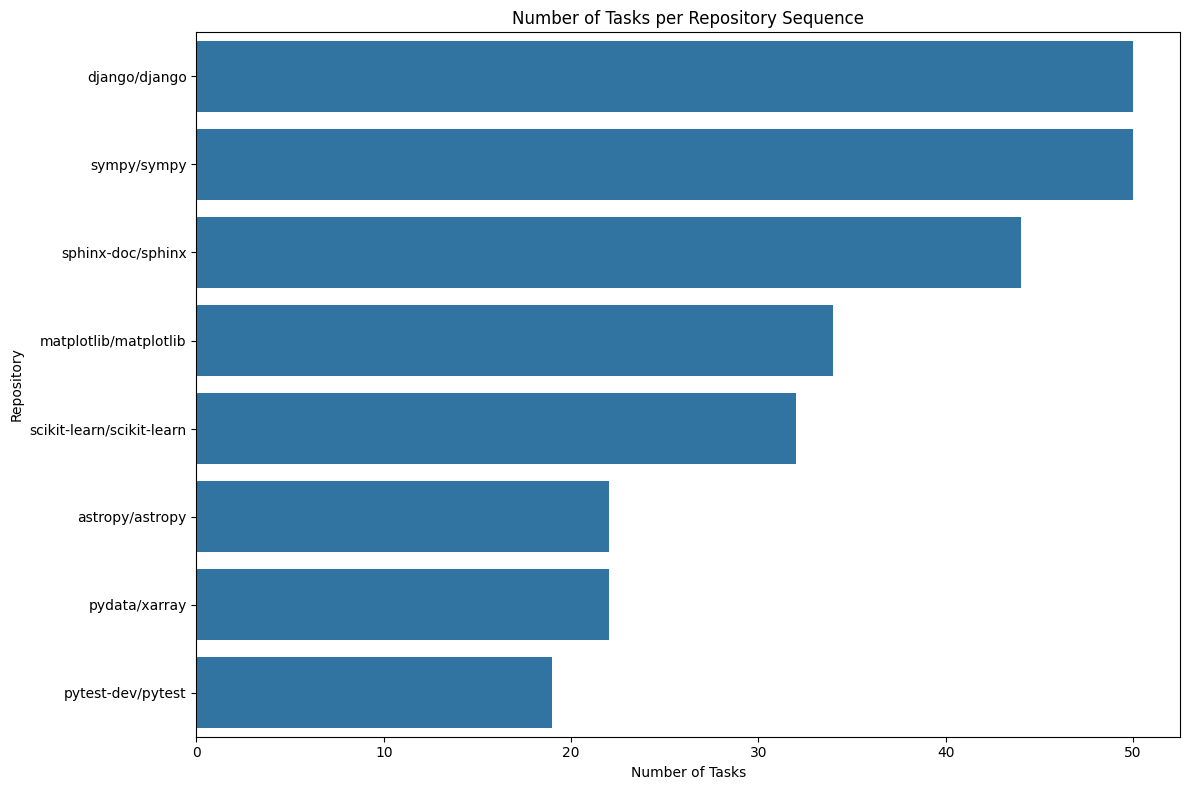

<Figure size 1200x800 with 0 Axes>

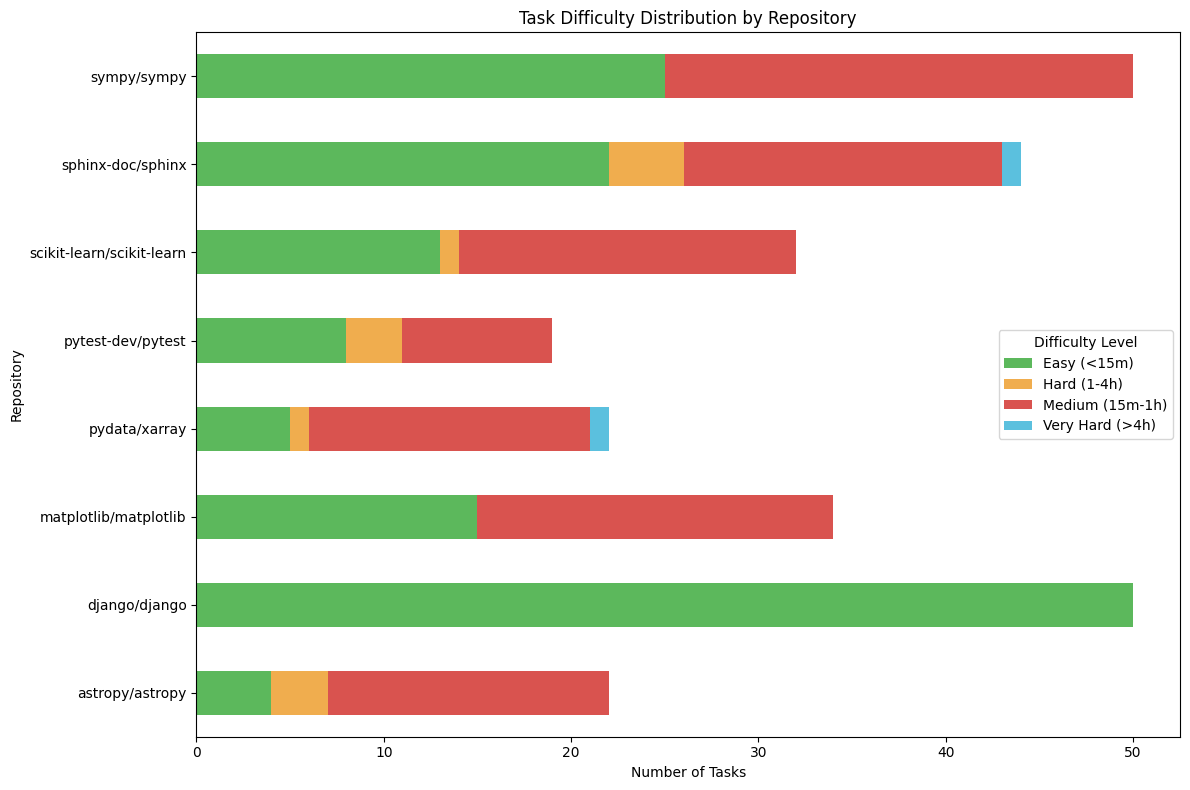

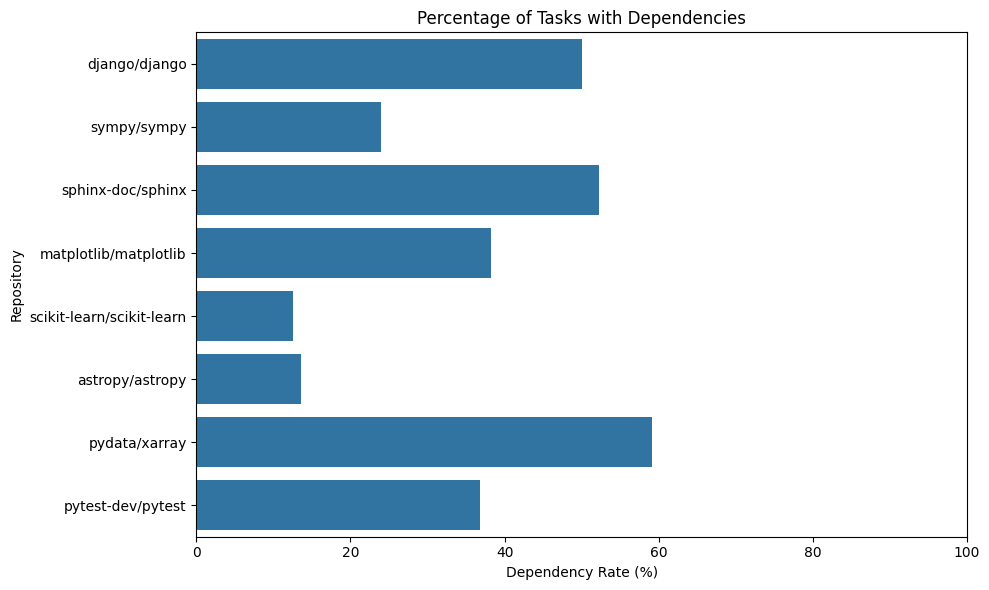

In [24]:
## 8. Dataset Visualization

# Visualize sequence composition
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))

# Sequence sizes
repos = [seq["repo"] for seq in swe_bench_cl["sequences"]]
task_counts = [seq["num_tasks"] for seq in swe_bench_cl["sequences"]]

# Create bar chart
sns.barplot(x=task_counts, y=repos)
plt.title("Number of Tasks per Repository Sequence")
plt.xlabel("Number of Tasks")
plt.ylabel("Repository")
plt.tight_layout()
# plt.savefig("sequence_sizes.png")
plt.show()

# Difficulty distribution
plt.figure(figsize=(12, 8))
difficulty_data = []

for seq in swe_bench_cl["sequences"]:
    repo = seq["repo"]
    for level, count in seq["statistics"]["difficulty_distribution"].items():
        difficulty_level = {
            1: "Easy (<15m)",
            2: "Medium (15m-1h)",
            3: "Hard (1-4h)",
            4: "Very Hard (>4h)"
        }[level]
        
        difficulty_data.append({
            "Repository": repo,
            "Difficulty": difficulty_level,
            "Count": count
        })

difficulty_df = pd.DataFrame(difficulty_data)
difficulty_pivot = difficulty_df.pivot(index="Repository", columns="Difficulty", values="Count").fillna(0)

# Ensure all difficulty levels are included (even if zero)
for level in ["Easy (<15m)", "Medium (15m-1h)", "Hard (1-4h)", "Very Hard (>4h)"]:
    if level not in difficulty_pivot.columns:
        difficulty_pivot[level] = 0

# Plot stacked bar chart
difficulty_pivot.plot(kind="barh", stacked=True, figsize=(12, 8), 
                     color=["#5cb85c", "#f0ad4e", "#d9534f", "#5bc0de"])
plt.title("Task Difficulty Distribution by Repository")
plt.xlabel("Number of Tasks")
plt.ylabel("Repository")
plt.legend(title="Difficulty Level")
plt.tight_layout()
# plt.savefig("difficulty_distribution.png")
plt.show()

# Dependencies visualization
plt.figure(figsize=(10, 6))
dependency_rates = [seq["statistics"]["dependency_rate"] for seq in swe_bench_cl["sequences"]]

sns.barplot(x=dependency_rates, y=repos)
plt.title("Percentage of Tasks with Dependencies")
plt.xlabel("Dependency Rate (%)")
plt.ylabel("Repository")
plt.xlim(0, 100)
plt.tight_layout()
# plt.savefig("dependency_rates.png")
plt.show()

In [25]:
## 9. Sample Task for Reference
# Display a sample task
sample_sequence = swe_bench_cl["sequences"][0]  # Django (first sequence)
sample_task = sample_sequence["tasks"][0]  # First task

print("Sample Task:")
print(json.dumps(sample_task, indent=2))

Sample Task:
{
  "metadata": {
    "instance_id": "django__django-9296",
    "repo": "django/django",
    "base_commit": "84322a29ce9b0940335f8ab3d60e55192bef1e50",
    "created_at": "2017-10-27T11:10:04+00:00",
    "difficulty": "<15 min fix"
  },
  "task": {
    "problem_statement": "Paginator just implement the __iter__ function\nDescription\n\t \n\t\t(last modified by Alex Gaynor)\n\t \nRight now, when you want to iter into all the pages of a Paginator object you to use the page_range function. It would be more logical and naturel to use the normal python of doing that by implementing the iter function like that:\ndef __iter__(self):\n\tfor page_num in self.page_range:\n\t\tyield self.page(page_num)\n",
    "hints_text": "Reformatted, please use the preview button in the future.\nI'm not sure that's common enough functionality to worry about.\nSo, some 9 years later we have a \u200bPR with this exact suggestion implemented... I'm going to reopen and Accept. Seems reasonable enough,